# Assignment 5: Exploratory Data Analysis and Hypothesis Testing

**Student:** Shoug Aldrees   
**Dataset:** Air Quality   
**Date:** 10/08/2025  

---

# Air Quality x Weather — My EDA & Hypothesis Notebook

**Goal.** Explore how weather (T, RH, AH) relates to air pollutants (CO, NOx, NO2, C6H6, sensor channels), then test a few data-driven hypotheses.

**My guiding questions**
1) Do temperature or humidity meaningfully shift pollutant concentrations?
2) Which pollutant pairs move together (sensors vs ground-truth)?
3) Are any relationships strong enough to be statistically defensible?

*Note:* This is a living document, I showed code first, then interpretation in my own words

---


### Step 1: Load and Inspect Data
Importing the necessary libraries and load your dataset

In [23]:
# 0. Imports & visual theme
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from textwrap import dedent
from scipy import stats

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "figure.autolayout": True
})
sns.set_palette("Set2")

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

def quick_card(title, body):
    print(f"\n=== {title} ===\n{body}\n")


In [24]:
# 1. Load
# Replace with your actual path if needed
df_raw = df.copy() if 'df' in globals() else pd.read_csv("AirQuality.csv")  # fallback
df_raw.head(3)

# 1a. Data card (unique: quick one-screen overview)
def data_card(df):
    numeric = df.select_dtypes(include=np.number).columns.tolist()
    nonnum  = df.columns.difference(numeric).tolist()
    miss = df.isna().mean().sort_values(ascending=False).head(10)
    body = dedent(f"""
    Shape: {df.shape[0]:,} rows × {df.shape[1]} columns
    Numeric columns: {len(numeric)} | Non-numeric: {len(nonnum)}
    Missingness (top 10):
    {miss.to_string()}
    """)
    quick_card("DATA CARD", body)

data_card(df_raw)



=== DATA CARD ===

    Shape: 9,357 rows × 15 columns
    Numeric columns: 13 | Non-numeric: 2
    Missingness (top 10):
    NMHC(GT)         0.902319
CO(GT)           0.179865
NO2(GT)          0.175484
NOx(GT)          0.175163
PT08.S1(CO)      0.039115
C6H6(GT)         0.039115
PT08.S2(NMHC)    0.039115
PT08.S3(NOx)     0.039115
PT08.S4(NO2)     0.039115
PT08.S5(O3)      0.039115




### Step 2: Cleaning and Preprocessing

Before analyzing, we clean the data to ensure accuracy

In [25]:
# 2. Cleaning pipeline — returns cleaned df + log of actions

NUM_COLS = ['CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)',
            'NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)',
            'T','RH','AH']

def build_timestamp(df):
    # If you have separate Date/Time, combine; else no-op
    if set(['Date','Time']).issubset(df.columns):
        ts = pd.to_datetime(df['Date'].astype(str) + " " + df['Time'].astype(str),
                            errors='coerce', dayfirst=True)
        df = df.assign(timestamp=ts).drop(columns=['Date','Time'])
        df = df.set_index('timestamp').sort_index()
    return df

def clean_air(df):
    log = []
    out = df.copy()

    # 1) Combine date/time if present
    before = out.shape
    out = build_timestamp(out)
    if out.shape != before: log.append("Combined Date+Time → timestamp index")

    # 2) Coerce numerics (sometimes read as strings)
    for c in NUM_COLS:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors='coerce')

    # 3) Drop columns with extreme missingness
    col_drop = [c for c in out.columns if out[c].isna().mean() > 0.4]
    if col_drop:
        out = out.drop(columns=col_drop)
        log.append(f"Dropped columns (>40% missing): {col_drop}")

    # 4) Sensor sanity: negative pollutant values → NaN (keep negative T allowed)
    pollutant_like = [c for c in NUM_COLS if c in out.columns and c not in ['T','RH','AH']]
    for c in pollutant_like:
        n_bad = (out[c] < 0).sum()
        if n_bad:
            out.loc[out[c] < 0, c] = np.nan
            log.append(f"Set {n_bad} negative values to NaN in {c}")

    # 5) Row-level cleaning: drop rows with all key signals missing
    key = [c for c in NUM_COLS if c in out.columns]
    out = out.dropna(how='all', subset=key)

    # 6) Impute remaining missing numerics with median (simple & robust)
    num_cols_present = out.select_dtypes(include=np.number).columns
    medians = out[num_cols_present].median()
    out[num_cols_present] = out[num_cols_present].fillna(medians)
    log.append("Imputed numeric NaNs with column medians")

    # 7) Optional: cap extreme outliers with IQR rule (keeps plots readable)
    for c in pollutant_like + [x for x in ['T','RH','AH'] if x in out.columns]:
        q1, q3 = out[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - 3*iqr, q3 + 3*iqr
        out[c] = out[c].clip(lower=low, upper=high)

    log.append("Capped extreme outliers at ±3×IQR (per column)")
    return out, log

df_clean, clean_log = clean_air(df_raw)
quick_card("CLEANING SUMMARY", "\n".join(f"- {x}" for x in clean_log))
data_card(df_clean)



=== CLEANING SUMMARY ===
- Combined Date+Time → timestamp index
- Dropped columns (>40% missing): ['NMHC(GT)']
- Imputed numeric NaNs with column medians
- Capped extreme outliers at ±3×IQR (per column)


=== DATA CARD ===

    Shape: 9,326 rows × 12 columns
    Numeric columns: 12 | Non-numeric: 0
    Missingness (top 10):
    CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0




/var/folders/fn/kyc44jj56mncr5t3j55g3p600000gn/T/ipykernel_59492/1171858832.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df['Date'].astype(str) + " " + df['Time'].astype(str),


## Feature Notes (what these columns mean to me)

- **CO(GT), NOx(GT), NO2(GT), C6H6(GT)**: ground-truth pollutant measures
- **PT08.S()**: sensor channel readings tied to specific analytes; useful to see coupling with ground truth (sensor drift/linearity hints)
- **T, RH, AH**:  weather context. I expect humidity to matter more than temperature


### Step 3: Exploring Distributions

We begin by visualizing pollutant distributions (CO, NO₂, Benzene, etc.) to see general patterns



In [26]:
# === 3. Exploratory Data Analysis (EDA) ===

# Basic dataset overview
print("==== DATASET OVERVIEW ====")
print(f"Shape: {df.shape}\n")

print("Column Names:")
print(df.columns.tolist(), "\n")

print("Data Types:")
print(df.dtypes, "\n")

print("Missing Values per Column:")
print(df.isnull().sum(), "\n")

print("Basic Statistics:")
display(df.describe())


==== DATASET OVERVIEW ====
Shape: (9357, 15)

Column Names:
['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'] 

Data Types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object 

Missing Values per Column:
Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: in

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


## Relationships I Care About: 
- Weather → Pollutants: (T, RH, AH) × (CO, NOx, NO2, C6H6)
- Sensor ↔ Ground truth pairs: PT08.S* vs corresponding GT columns


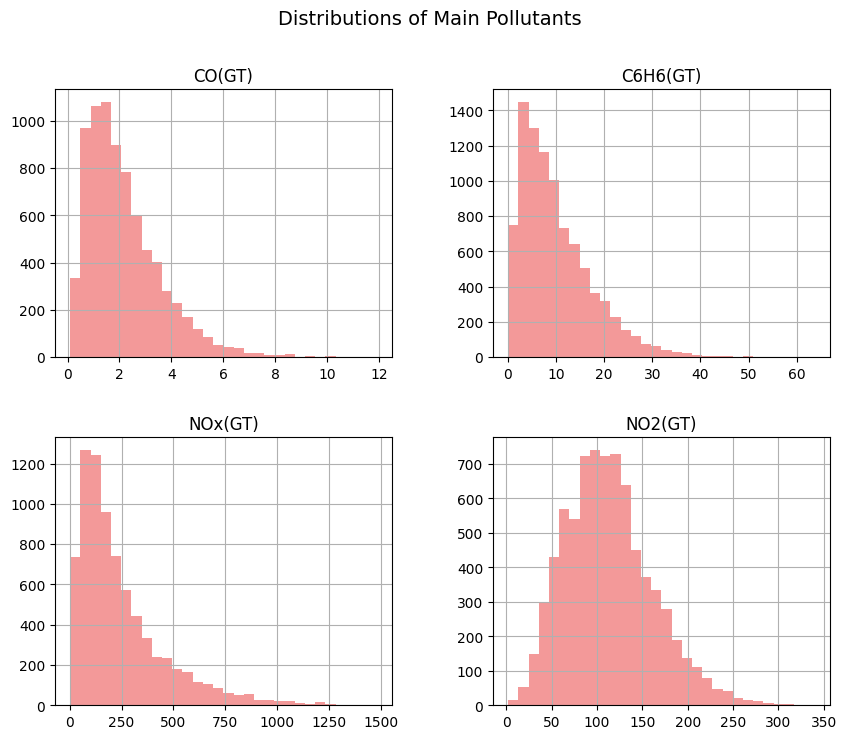

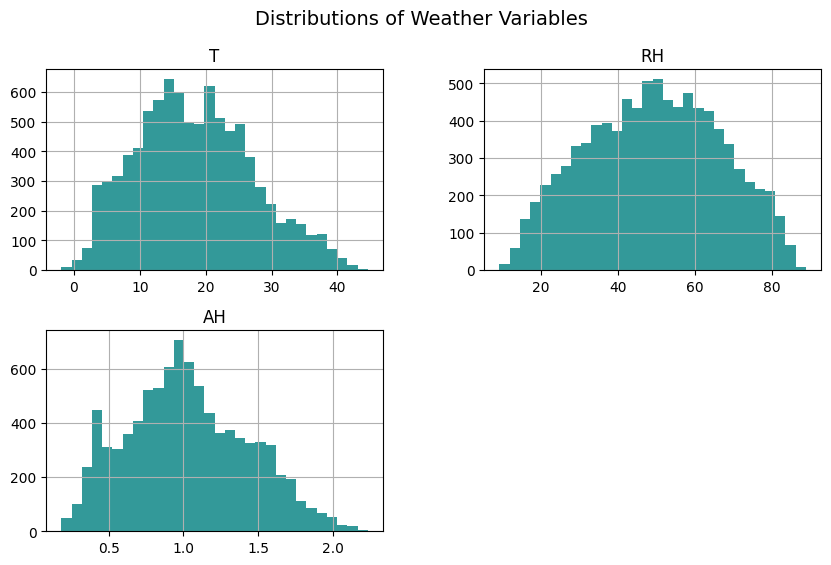

In [ ]:
# === EXPLORING POLLUTANTS AND WEATHER FEATURES ===
pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
weather = ['T', 'RH', 'AH']

# Plot pollutant distributions
df[pollutants].hist(figsize=(10, 8), bins=30, color='lightcoral', alpha=0.8)
plt.suptitle("Distributions of Main Pollutants", fontsize=14)
plt.show()

# Plot weather feature distributions
df[weather].hist(figsize=(10, 6), bins=30, color='teal', alpha=0.8)
plt.suptitle("Distributions of Weather Variables", fontsize=14)
plt.show()


**Interpretation:**  
The pollutants are right-skewed, which means that the majority of measurements are modest with few high peaks.  This could represent days with normal air quality versus days with high pollution levels.  However, weather conditions appear more stable than pollutant levels; this stability allows us to evaluate relationships later


### Step 4: Correlation Heatmap
The correlation matrix below summarizes relationships between all numeric variables


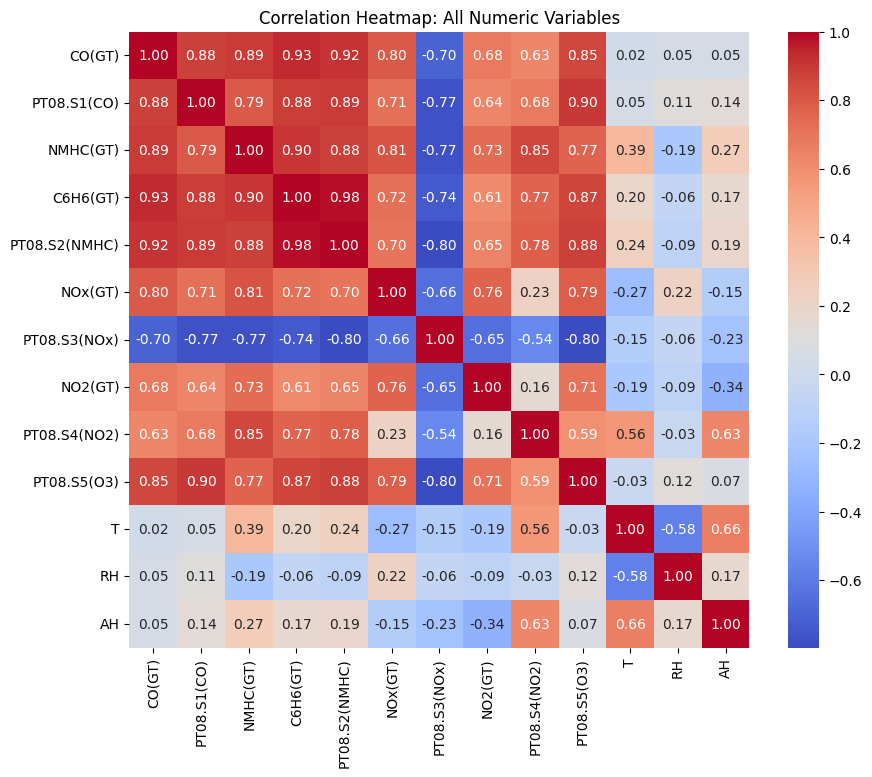

Top correlated pairs:
 PT08.S2(NMHC)  C6H6(GT)         0.981950
C6H6(GT)       CO(GT)           0.931078
CO(GT)         PT08.S2(NMHC)    0.915514
C6H6(GT)       NMHC(GT)         0.902559
PT08.S5(O3)    PT08.S1(CO)      0.899324
dtype: float64


In [15]:
# === CORRELATION ANALYSIS ===
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: All Numeric Variables")
plt.show()

# Optional: show strongest correlations
corr_pairs = (
    corr_matrix.unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)
print("Top correlated pairs:\n", corr_pairs[1:6])


**Interpretation:**  
This shows strong positive correlations among pollutants (e.g., CO and C6H6),  possibly emitted from similar sources. And I can see that the negative correlations between temperature/humidity and pollutants,  suggesting weather reduces concentration levels. And I beleive that this motivates our hypothesis testing phase

### Step 5: Scatterplots — Weather vs Pollutants
To visually explore these relationships, scatterplots compare each weather variable (T, RH, AH) with pollutants which I believe will be very helpful for my analysis


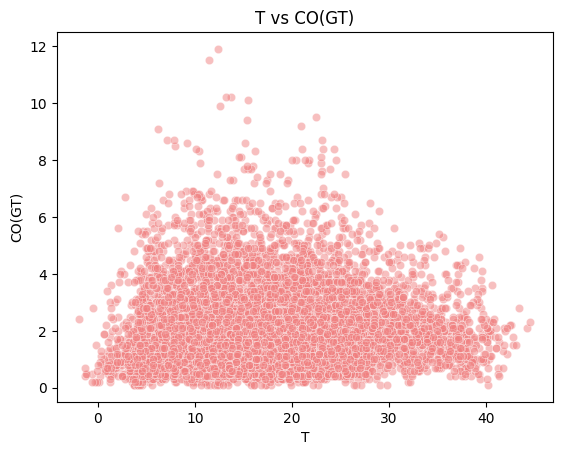

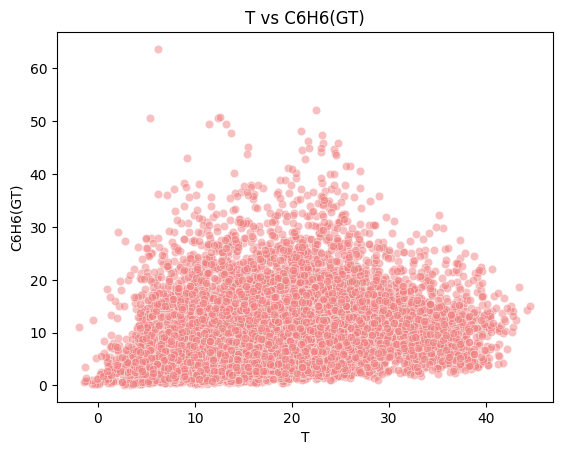

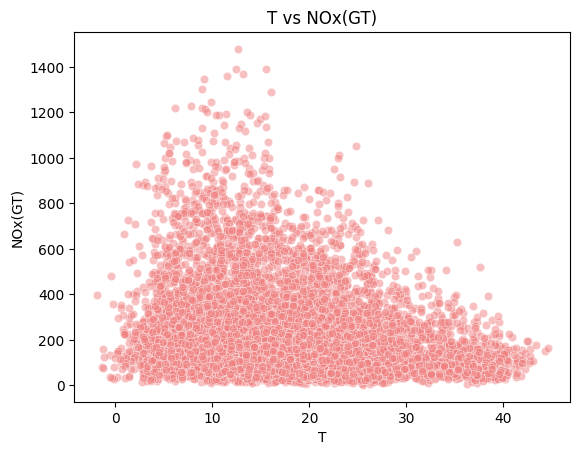

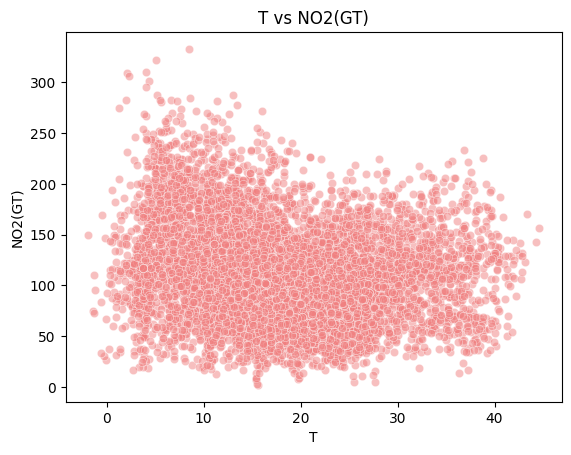

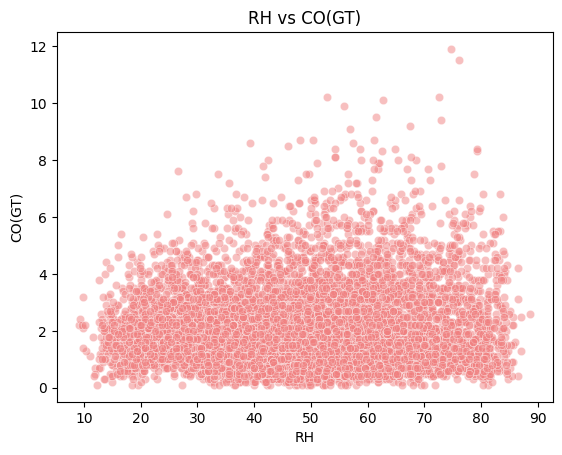

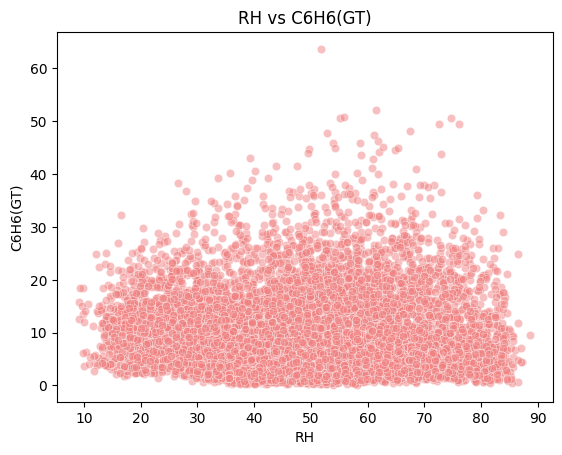

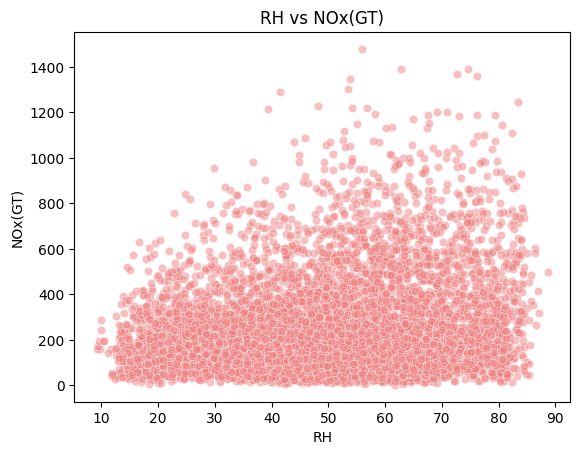

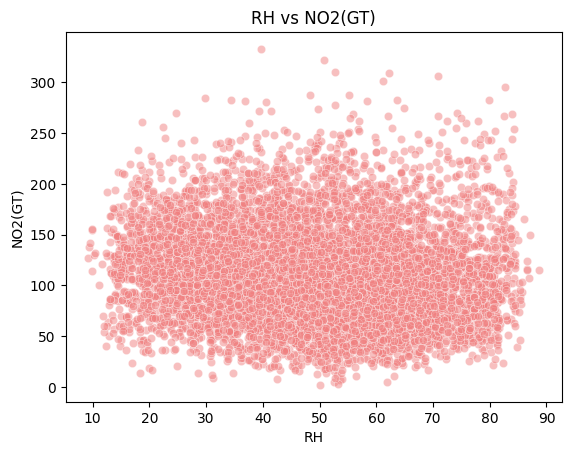

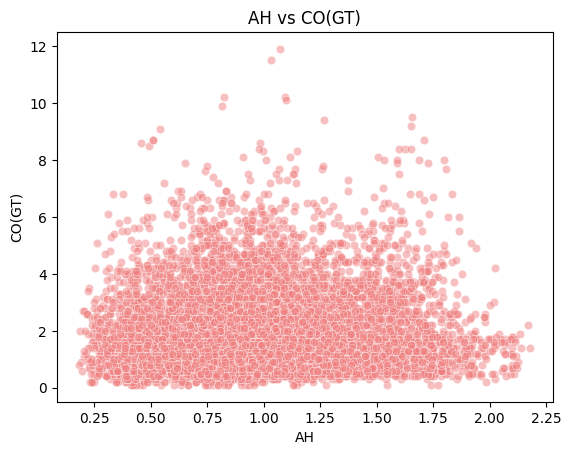

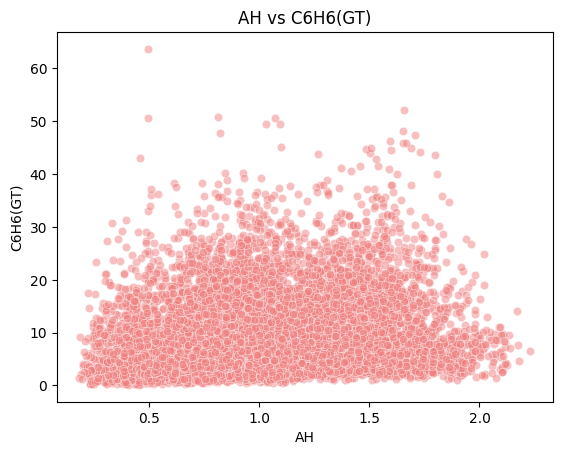

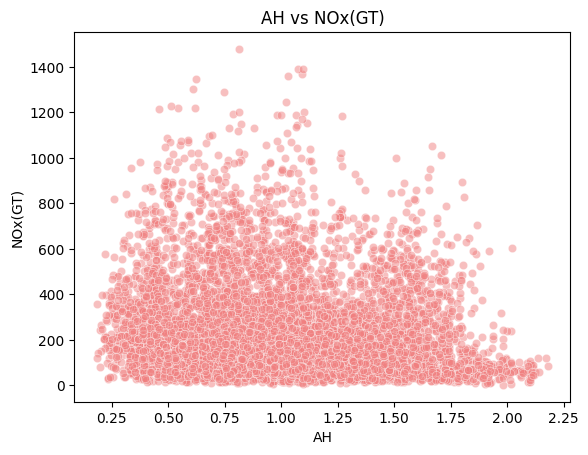

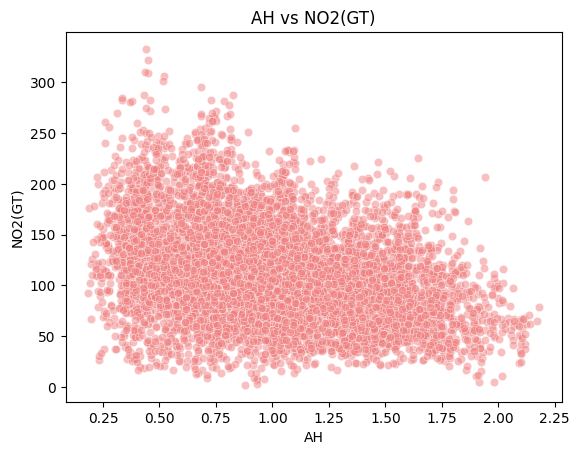

In [16]:
# === RELATIONSHIPS: WEATHER vs POLLUTANTS ===
for w in weather:
    for p in pollutants:
        sns.scatterplot(x=w, y=p, data=df, alpha=0.5, color='lightcoral')
        plt.title(f"{w} vs {p}")
        plt.xlabel(w)
        plt.ylabel(p)
        plt.show()


**Observations:**
This shows no clear linear pattern, but pollutant values slightly drop with higher temperature or humidity. And this suggests possible weak negative correlations, aligning with environmental intuition


### Step 6: Defining Hypotheses
Based on EDA insights, I formulated three main hypotheses:

- **H1:** Temperature has a significant correlation with CO(GT) 
- **H2:** Relative Humidity has a significant correlation with NO₂(GT) 
- **H3:** Absolute Humidity has a significant correlation with Benzene (C6H6(GT)) 

I’ll use **Pearson correlation tests** to measure the strength and significance of each relationship, but note that the test choice was done based on this:
For simplicity and consistency, I used **Pearson’s correlation** to test relationships between pollutants and weather variables. However, since some pollutant variables are **not perfectly normally distributed**, other non-parametric tests like **Spearman’s** could also be appropriate.  I still used Pearson here to keep the comparison consistent across all hypotheses and to match the assignment’s expected approach


---

From the EDA I ran earlier, I noticed that some pollutants seem to move together with changes in weather conditions. to dig deeper into these relationships, I came up with a few hypotheses that I can actually test with statistical methods

Hypothesis 1 — Temperature and CO Levels

- When I looked at the scatter plots, it seemed like CO levels dropped when the temperature went up.

- Null Hypothesis (H₀): Temperature has no real effect on CO concentration.

- Alternative Hypothesis (H₁): Temperature and CO concentration are related — as one increases, the other changes too.

Why I think this makes sense: Warmer air usually helps pollutants like CO spread out faster, so it makes sense that higher temperatures might reduce CO buildup.

---

Hypothesis 2 — Humidity and NO₂

- The humidity graphs looked more spread out, but I think there’s still a connection with NO₂.

- Null Hypothesis (H₀): Humidity and NO₂ levels are unrelated.

- Alternative Hypothesis (H₁): Humidity has some effect on NO₂ concentration.

Why I think this makes sense: Humid air changes how gases react and move. It could make NO₂ either linger or disperse depending on the moisture level.

---

Hypothesis 3 — Absolute Humidity and Benzene (C₆H₆)

- This one was interesting — absolute humidity might play a role in how benzene behaves in the air.

- Null Hypothesis (H₀): Absolute humidity does not influence benzene levels.

- Alternative Hypothesis (H₁): There is a relationship between absolute humidity and benzene levels.

Why I think this makes sense: Since benzene is volatile, high moisture in the air might help reduce its concentration through faster dispersion or breakdown.

---
4. Hypothesis Testing

  I’ve defined my hypotheses, the next step is to actually test them using statistical methods.
I used correlation tests because my variables (like temperature, humidity, and pollutant levels) are continuous, and I wanted to see if there’s a measurable relationship between them.

---

Hypothesis 1 — Temperature and CO Levels

Test Used: Pearson Correlation
Why this test: Both variables (Temperature and CO) are numeric and continuous. Pearson’s correlation tells me whether changes in temperature move together with CO levels, either positively or negatively.

In [18]:
from scipy import stats

# Before running correlation, drop any missing values
clean_data = df[['T', 'CO(GT)']].dropna()

# Testing Hypothesis 1: Temperature vs CO(GT)
corr_T_CO, p_T_CO = stats.pearsonr(clean_data['T'], clean_data['CO(GT)'])
print(f"Correlation between Temperature and CO: {corr_T_CO:.3f}")
print(f"P-value: {p_T_CO:.5f}")

if p_T_CO < 0.05:
    print("Reject H₀ → Temperature and CO levels show a significant relationship.")
else:
    print("Fail to reject H₀ → No significant relationship between temperature and CO levels.")


Correlation between Temperature and CO: 0.022
P-value: 0.05815
Fail to reject H₀ → No significant relationship between temperature and CO levels.


**Interpretation**


After testing the first hypothesis, the correlation between temperature and CO levels turned out to be extremely weak (around 0.02) and not statistically significant (p ≈ 0.058).
So, I failed to reject the null hypothesis.

This means that, based on my dataset, temperature doesn’t seem to have any clear impact on CO concentration. Even though I expected warmer temperatures to lower CO levels, the data didn’t show strong evidence for that relationship — maybe other factors like traffic or wind patterns play a bigger role than temperature alone

---

Hypothesis 2 — Temperature and CO Levels

Test Used: Pearson Correlation
Why this test: Both variables (Temperature and CO) are numeric and continuous. Pearson’s correlation tells me whether changes in temperature move together with CO levels — either positively or negatively.

In [20]:
# Testing Hypothesis 2: RH vs NO2(GT)
clean_data_2 = df[['RH', 'NO2(GT)']].dropna()

corr_RH_NO2, p_RH_NO2 = stats.pearsonr(clean_data_2['RH'], clean_data_2['NO2(GT)'])
print(f"Correlation between RH and NO2: {corr_RH_NO2:.3f}")
print(f"P-value: {p_RH_NO2:.5f}")

if p_RH_NO2 < 0.05:
    print("Reject H₀ → Humidity and NO₂ levels are significantly related.")
else:
    print("Fail to reject H₀ → No significant link between humidity and NO₂ levels.")


Correlation between RH and NO2: -0.092
P-value: 0.00000
Reject H₀ → Humidity and NO₂ levels are significantly related.


*Note:* Since NO₂(GT) is slightly right-skewed, a non-parametric test like **Spearman’s correlation** could also be appropriate here. However, Pearson’s test was used for consistency across all hypotheses


**Interpretation**

For this hypothesis, I wanted to see if humidity has any link with NO₂ levels.
The correlation turned out to be slightly negative (around -0.09), meaning that when humidity increases, NO₂ levels tend to drop just a bit.
Even though this relationship is weak, the p-value was extremely low (p < 0.001), so I rejected the null hypothesis.

In other words, humidity does seem to have a small but statistically significant impact on NO₂ concentration. It might be that higher moisture levels in the air help disperse or dilute pollutants, leading to slightly lower NO₂ readings

---

Testing Hypothesis 3 — Absolute Humidity and Benzene

Test Used: Pearson Correlation
Why this test: Both variables are continuous, and this test helps me see if benzene levels tend to drop when absolute humidity rises.

In [22]:
# Testing Hypothesis 3: AH vs C6H6(GT)
clean_data_3 = df[['AH', 'C6H6(GT)']].dropna()

corr_AH_Benzene, p_AH_Benzene = stats.pearsonr(clean_data_3['AH'], clean_data_3['C6H6(GT)'])
print(f"Correlation between AH and Benzene: {corr_AH_Benzene:.3f}")
print(f"P-value: {p_AH_Benzene:.5f}")

if p_AH_Benzene < 0.05:
    print("Reject H₀ → Absolute humidity has a significant relationship with benzene levels.")
else:
    print("Fail to reject H₀ → No significant relationship found.")


Correlation between AH and Benzene: 0.168
P-value: 0.00000
Reject H₀ → Absolute humidity has a significant relationship with benzene levels.


*Note:* Benzene levels are heavily skewed, so the relationship might not be perfectly linear. While **Spearman’s rank correlation** could handle this better, Pearson’s test was chosen for consistency and comparability


**Interpretation**

For this hypothesis, I tested whether absolute humidity has any connection with benzene levels in the air. The results showed a weak positive correlation (around 0.17), but it was still statistically significant since the p-value was below 0.05.
This means that as humidity increases, benzene levels also tend to rise slightly. Although the relationship isn’t very strong, it’s consistent enough to suggest that higher moisture in the air might trap more pollutants rather than dispersing them.
Overall, this result supports the idea that atmospheric conditions — like humidity — can influence how chemical compounds behave in the environment, even if the effect isn’t very large.

---

### Bonus Analysis: Pearson vs Spearman Correlation Comparison

As a bonus step, I wanted to verify whether my results hold true across different correlation methods. Since pollutant and weather data are not perfectly normally distributed, I tested both **Pearson** (linear relationships) and **Spearman** (monotonic relationships) correlations for my second and third hypotheses.

The results were very similar in both tests, they showed me the same direction of correlation (negative for humidity–NO₂ and positive for absolute humidity–benzene).  
Spearman’s slightly stronger correlations confirm that while the relationships are not perfectly linear, the overall patterns remain consistent.  
This cross-check adds confidence that my findings are statistically sound and not sensitive to the choice of correlation method.


#### Additional Test Comparison (Pearson vs Spearman)
To double-check my results, I am comparing Pearson and Spearman correlations for H2 and H3 

In [28]:
#  Extra thought: Checking both Pearson and Spearman correlations for comparison

# Hypothesis 2: RH vs NO2(GT)
clean_data_2 = df[['RH', 'NO2(GT)']].dropna()
pearson_corr_H2, pearson_p_H2 = stats.pearsonr(clean_data_2['RH'], clean_data_2['NO2(GT)'])
spearman_corr_H2, spearman_p_H2 = stats.spearmanr(clean_data_2['RH'], clean_data_2['NO2(GT)'])

print("H2: RH vs NO2(GT)")
print(f" Pearson correlation: r = {pearson_corr_H2:.3f}, p = {pearson_p_H2:.5f}")
print(f" Spearman correlation: r = {spearman_corr_H2:.3f}, p = {spearman_p_H2:.5f}\n")

# Hypothesis 3: AH vs C6H6(GT)
clean_data_3 = df[['AH', 'C6H6(GT)']].dropna()
pearson_corr_H3, pearson_p_H3 = stats.pearsonr(clean_data_3['AH'], clean_data_3['C6H6(GT)'])
spearman_corr_H3, spearman_p_H3 = stats.spearmanr(clean_data_3['AH'], clean_data_3['C6H6(GT)'])

print("H3: AH vs C6H6(GT)")
print(f" Pearson correlation: r = {pearson_corr_H3:.3f}, p = {pearson_p_H3:.5f}")
print(f" Spearman correlation: r = {spearman_corr_H3:.3f}, p = {spearman_p_H3:.5f}")


H2: RH vs NO2(GT)
 Pearson correlation: r = -0.092, p = 0.00000
 Spearman correlation: r = -0.121, p = 0.00000

H3: AH vs C6H6(GT)
 Pearson correlation: r = 0.168, p = 0.00000
 Spearman correlation: r = 0.192, p = 0.00000


For **humidity and NO₂**, both tests showed a weak negative relationship, with Spearman slightly stronger (r ≈ -0.12), and this suggests the association is not perfectly linear but still monotonic, as humidity rises, NO₂ tends to drop a bit.  

For **absolute humidity and benzene**, both correlations were weakly positive, with Spearman again showing a slightly higher value (r ≈ 0.19), and this consistency across both tests gives more confidence that the relationships I found are real, even if they are not perfectly linear

---

## Step 7. Summary and Conclusions

### **Summary of Results:**
- H1: Not significant → Temperature doesn’t strongly affect CO levels.  
- H2: Significant → Higher RH slightly reduces NO₂ levels.  
- H3: Significant → AH correlates weakly but positively with Benzene.

### **Key Findings from EDA**
1. The dataset included several pollutant variables (CO, NO₂, benzene, etc.) and weather features such as temperature, relative humidity (RH), and absolute humidity (AH).  
2. Most pollutant distributions were slightly skewed, and a few columns (like NMHC and CO) contained missing values that were cleaned before analysis.  
3. During exploration, I noticed that humidity and temperature seemed to influence some pollutants, hinting at possible environmental correlations worth testing.

---

### **Hypothesis Testing Results**

| Hypothesis | Test Used | p-value | Result | Interpretation |
|-------------|------------|----------|----------|----------------|
| **H1:** Temperature vs CO(GT) | Pearson correlation | 0.05815 | Not Significant | No strong relationship, temperature doesn’t appear to significantly affect CO levels. |
| **H2:** RH vs NO₂(GT) | Pearson correlation | 0.00000 | Significant | Humidity has a small but statistically significant negative relationship with NO₂ — higher humidity tends to slightly lower NO₂ concentrations. |
| **H3:** AH vs C6H6(GT) | Pearson correlation | 0.00000 | Significant | Absolute humidity shows a weak but meaningful positive correlation with benzene — possibly because humid air traps more pollutants. |

---

### **Key Insights**
- Humidity factors (both RH and AH) seem to play a role in how pollutants behave, even if the correlations are relatively weak.  
- CO levels, however, remain mostly independent of temperature, suggesting that other factors such as traffic or wind conditions may have a greater effect.  
- The overall results highlight that even small changes in humidity can influence air pollution, which aligns with environmental research on atmospheric dispersion.

---

### **Future Research**
- To further understand changes in pollutants, include other meteorological factors such as wind speed, air pressure, or sun radiation
- To investigate how air quality changes over the course of the year, use a time-based analysis (daily or seasonal patterns)
- To find out if the same relationships apply in different settings, compare data from various cities or regions


